### Introduction and Motivation

For our ENSF 612 project, we trained various models to predict the total ride duration of taxi trips in New York City (NYC). We chose to study this dataset because it offered insights into traffic patterns in one of the world's fastest-moving cities.

Our dataset was sourced from [Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data?select=train.zip). The dataset was cleaned specifically for a competition, enabling our group to concentrate on exploratory data analysis (EDA) and model building.

In this notebook, we focused an Explaratory Data Analysis (EDA) and preliminary feature engineering.


### Connect to drive

In [ ]:
# connect to collab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# record time
import time

# start record
start = time.time()

Mounted at /content/drive


In [ ]:
# root directories
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/ENSF 612/project"

MEDIA_PATH = BASE_PATH  + "/media"
DATASET_PATH = BASE_PATH + "/dataset"

In [ ]:
# NYC dataset
TRAIN_DATASET = DATASET_PATH + "/" + "train.csv"

In [ ]:
""" Global Variables """

MAX_DURATION = 7200  # Maximum trip duration in seconds
MIN_DURATION = 180   # Minimum trip duration in seconds
MAX_DISTANCE = 60.0  # Maximum distance in kilometers
MIN_DISTANCE = 1.5   # Minimum distance in kilometers

DAY_OF_WEEK_MAPPING = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

### Library imports

In [ ]:
# normal imports
import os
import requests
from IPython.display import Image

# for dataframes
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# geodesic
from geopy.distance import geodesic

# calculation
from math import radians, cos, sin, asin, sqrt

### Setup Spark

In [ ]:
# Install Java Development Kit (required for Apache Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Apache Spark (version 3.5.0) with Hadoop (version 3)
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xf spark-3.5.0-bin-hadoop3.tgz

# Install the findspark library (used to locate and initialize Apache Spark)
!pip install -q findspark

# Set up the required environment variables for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Initialize findspark and import SparkSession
import findspark
findspark.init()

In [ ]:
# eda
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, dayofweek, hour, count, when, year, month, minute, quarter, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from pyspark.sql import functions as F
from pyspark.sql import types as T

# machine learning
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Create a Spark session and context
spark = SparkSession.builder.master("local").appName("Colab").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

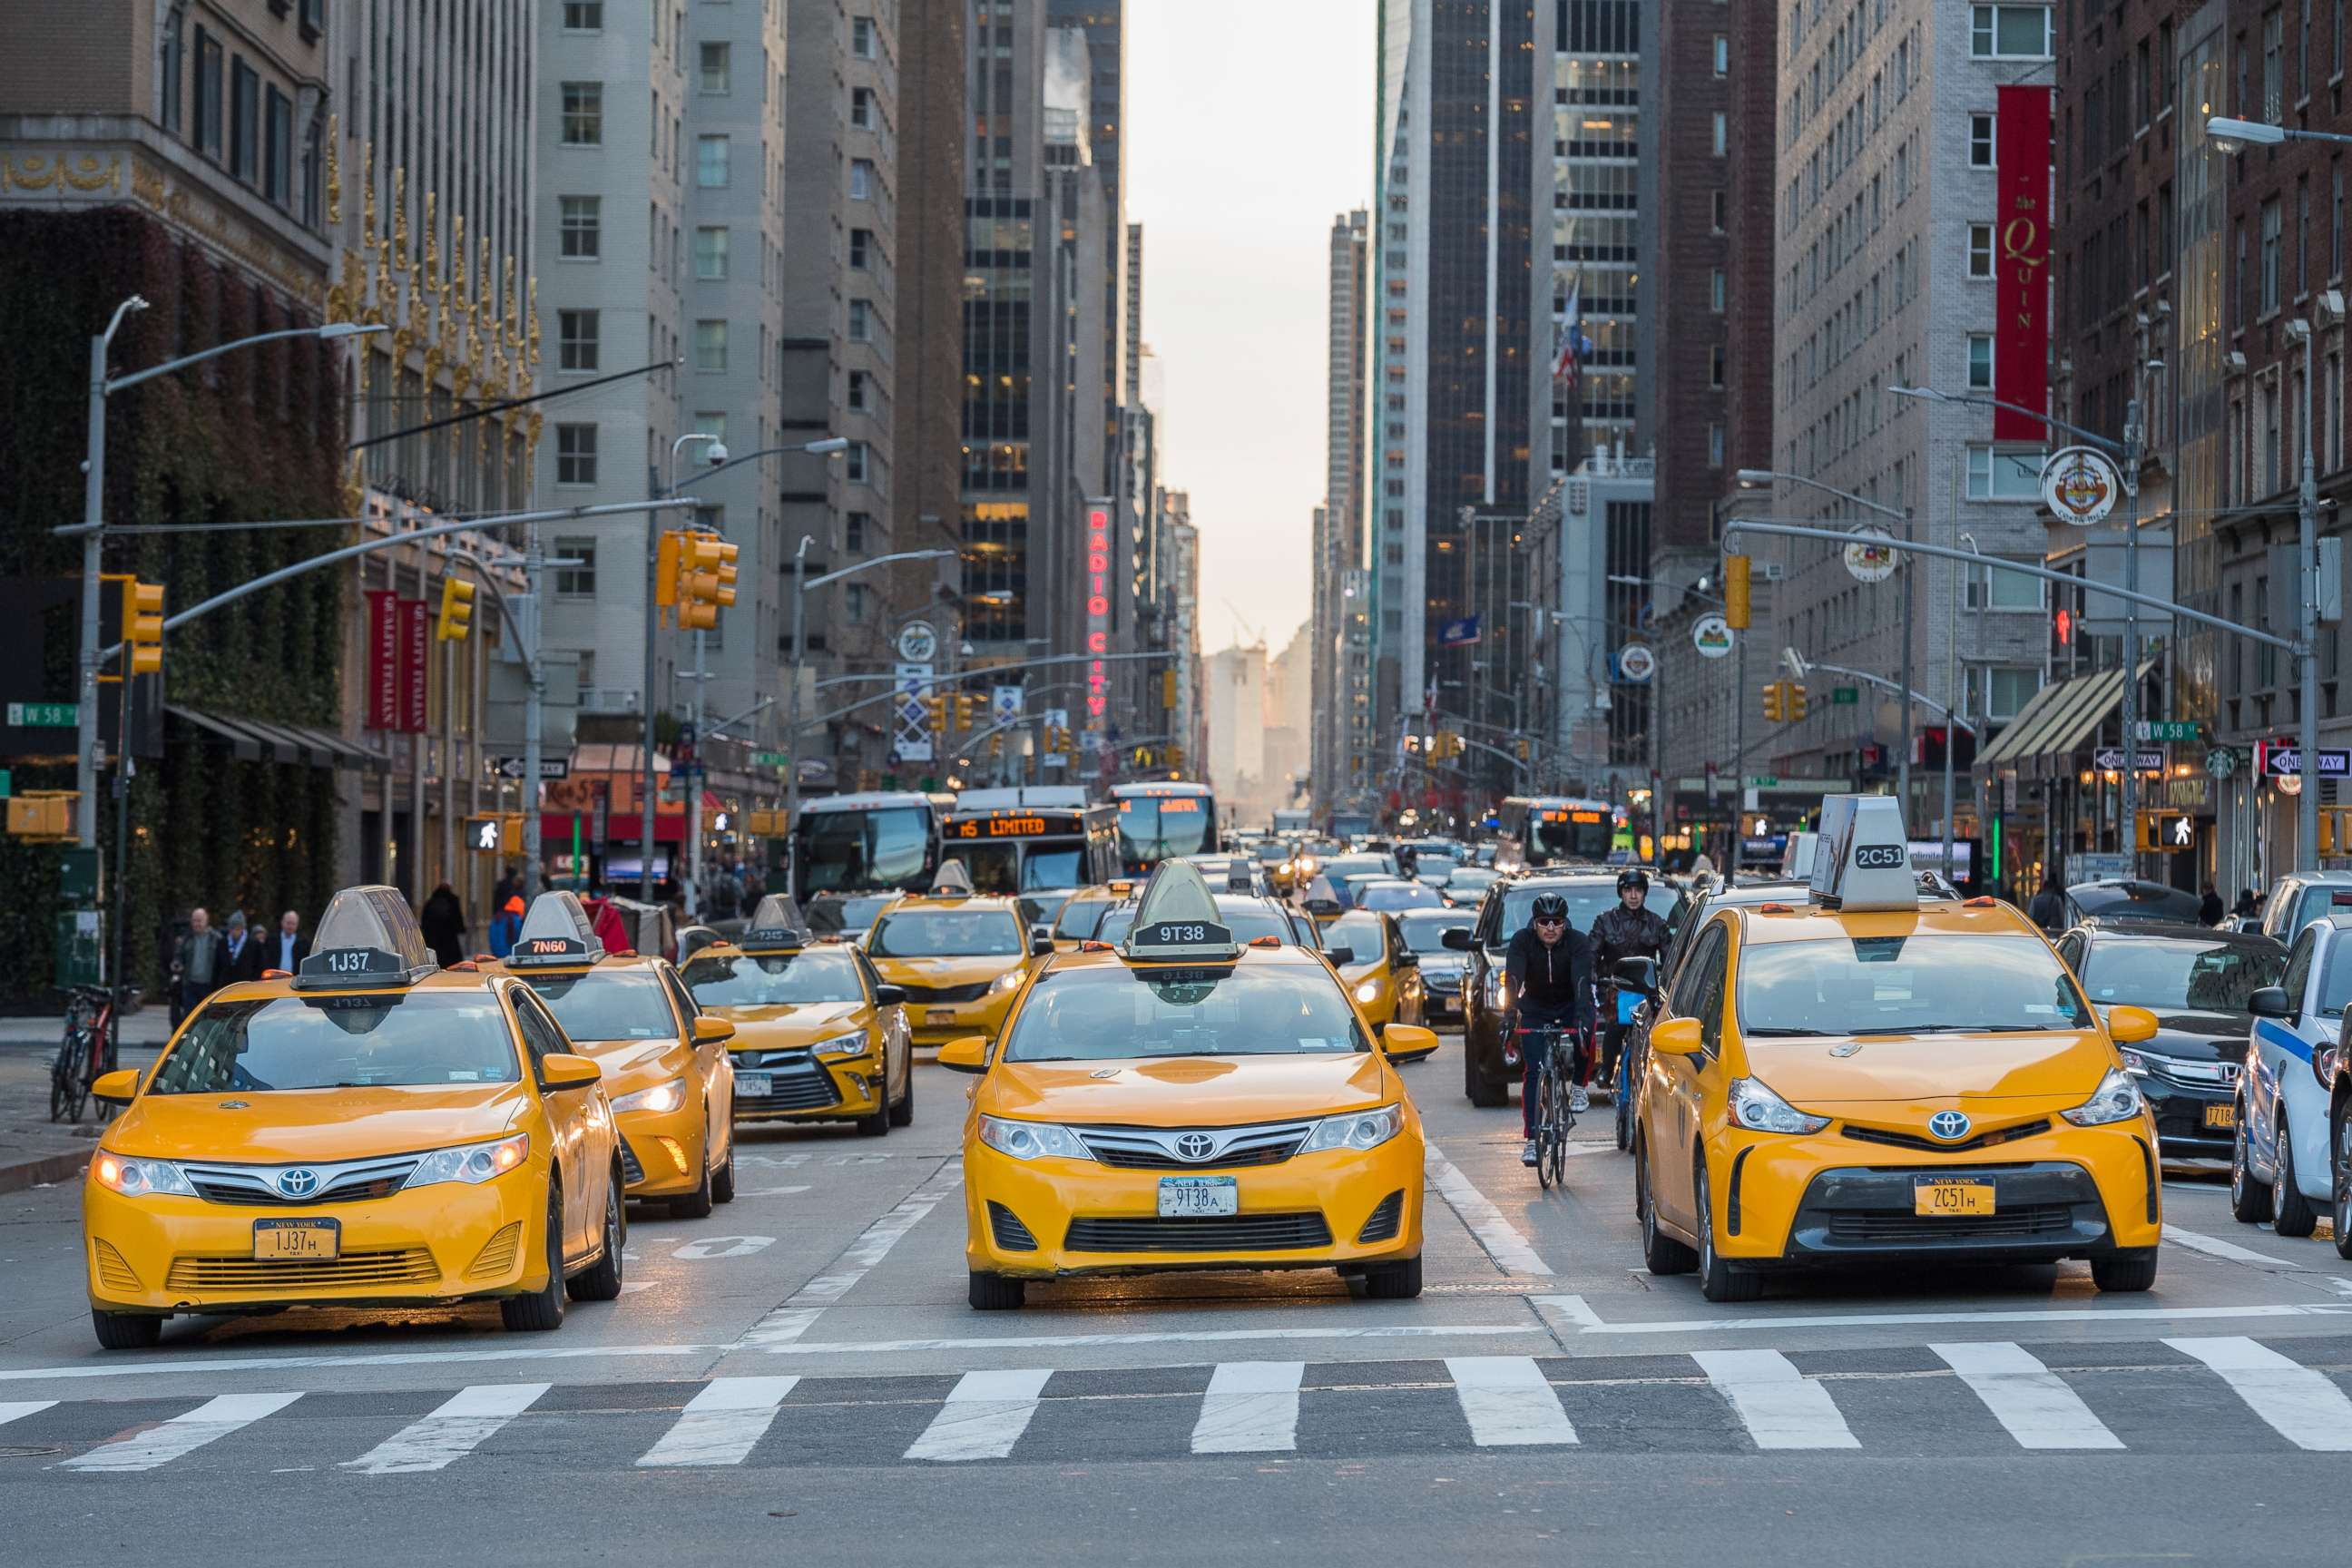

In [ ]:
nyc_image = MEDIA_PATH + "/nyc_image.jpg"
display(Image(filename=nyc_image))

### Data Inspection and Validation

We inspected the data for each of the following aspects:
1. Temporal and Geographical Consistency (Anomaly Detection):
- We examined data to ensure the logical coherence of time entries
- Verified temporal data falls within the designated longitude and latitude boundaries of New York City (NYC)
2. Verification of Expected Data:
- Examination of each column to confirm that it contains the expected values
3. Data Completeness:
- Checked to confirm the absence of any null values

### Read CSV

In [ ]:
spark = SparkSession.builder.appName("TaxiDataAnalysis").getOrCreate()

# Define the schema corresponding to the CSV file format
schema = StructType([
    StructField("id", StringType(), True),
    StructField("vendor_id", IntegerType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("pickup_longitude", FloatType(), True),
    StructField("pickup_latitude", FloatType(), True),
    StructField("dropoff_longitude", FloatType(), True),
    StructField("dropoff_latitude", FloatType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("trip_duration", IntegerType(), True)
])

# Read the CSV file into a DataFrame
taxi_df = spark.read.csv(TRAIN_DATASET, schema=schema, header=True)

## Initial Explaratory Data Analysis

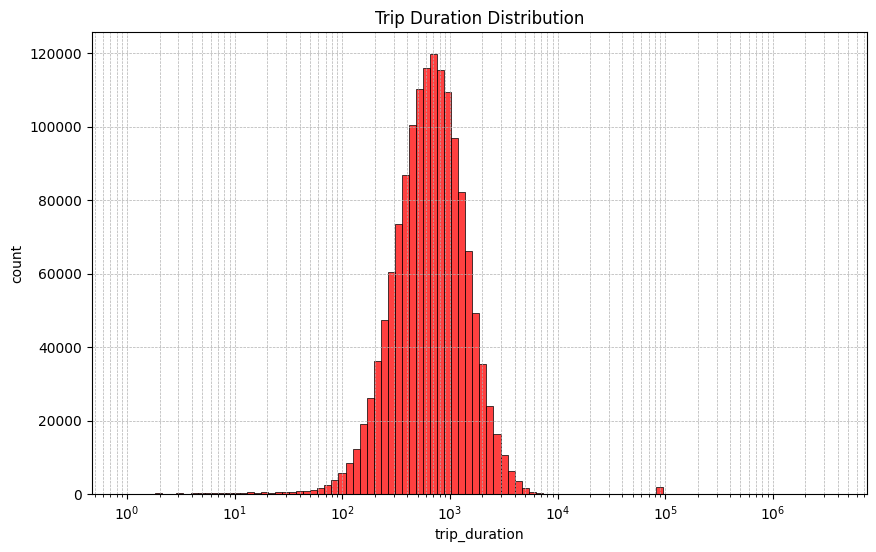

In [ ]:
trip_durations = taxi_df.select("trip_duration").rdd.flatMap(lambda x: x).collect()

# plot the histogram with a log scale
plt.figure(figsize=(10,6))
sns.histplot(trip_durations, log_scale=True, bins=100, kde=False, color="red")

plt.title("Trip Duration Distribution")
plt.xlabel("trip_duration")
plt.ylabel("count")
plt.xscale("log") # set the scale of the x-axis to loga
plt.yscale("linear")
plt.grid(True, which="both", ls="--", linewidth=0.5) # Adding a grid

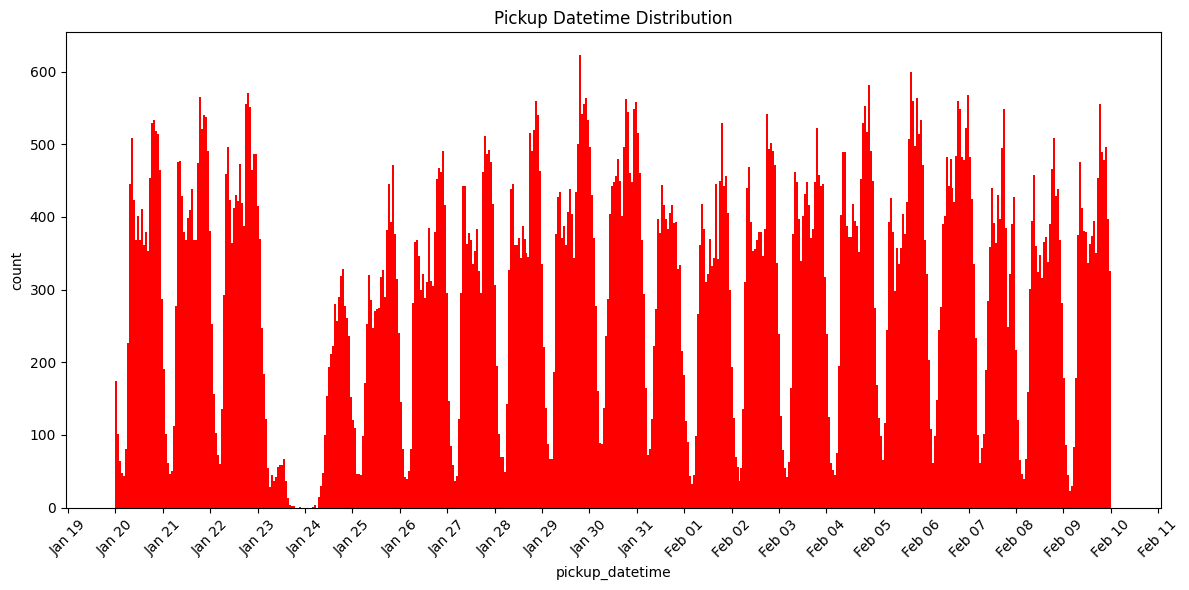

In [ ]:
# convert 'pickup_datetime' from string to timestamp.
taxi_df = taxi_df.withColumn('pickup_datetime', F.to_timestamp('pickup_datetime', 'yyyy-MM-dd HH:mm:ss'))

# filter the DataFrame for the date range
filtered_df = taxi_df.filter((F.col('pickup_datetime') > '2016-01-20') & (F.col('pickup_datetime') < '2016-02-10'))

# collect the data to the driver to pandas
pandas_df = filtered_df.select('pickup_datetime').toPandas()

plt.figure(figsize=(12,6))
plt.hist(pandas_df['pickup_datetime'], bins=500, color='red')

# Formatting the date on x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.title('Pickup Datetime Distribution')
plt.xlabel('pickup_datetime')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.tight_layout()

The graph above depicts the number of pickup times from January 20 to February 20. This dataset segment is intriguing because around January 24, there are no pickup counts. A search on the web revealed a massive snowstorm in NYC, leading to extremely hazardous driving conditions. What Casey Neistat video here: [SNOWBOARDING WITH THE NYPD](https://www.youtube.com/watch?v=qRv7G7WpOoU&ab_channel=CaseyNeistat)

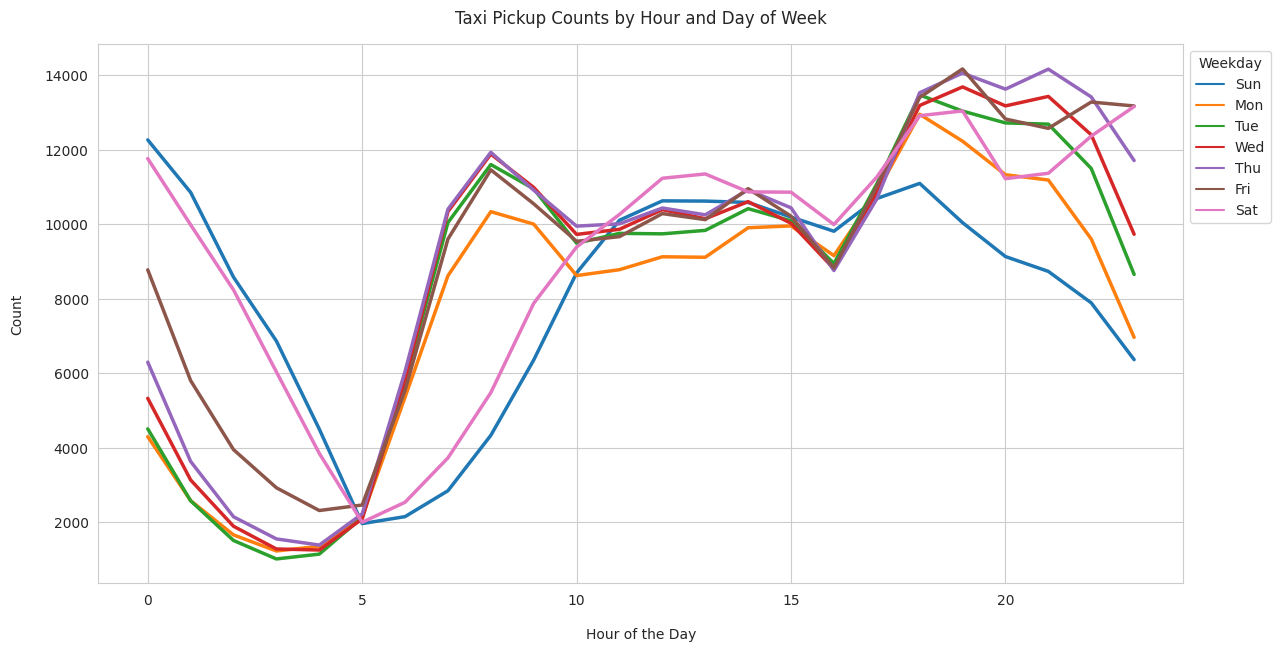

In [ ]:
# add day of the week and hour columns
taxi_df_with_time = taxi_df.withColumn("day_of_week", dayofweek(col("pickup_datetime"))) \
                           .withColumn("hour_of_day", hour(col("pickup_datetime")))

# group by day of the week and hour of day, and count pickups
pickup_counts = taxi_df_with_time.groupBy("day_of_week", "hour_of_day") \
                                 .count() \
                                 .orderBy("day_of_week", "hour_of_day")

# collect the data to the driver node
pickup_counts_pd = pickup_counts.toPandas()

# rename the days of the week from integer to actual names
day_of_week_dict = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
pickup_counts_pd['day_of_week'] = pickup_counts_pd['day_of_week'].map(day_of_week_dict)

sns.set_style("whitegrid")

plt.figure(figsize=(14, 7))
sns.lineplot(x='hour_of_day', y='count', hue='day_of_week', data=pickup_counts_pd, palette='tab10', linewidth=2.5)

plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Count', labelpad=15)
plt.title('Taxi Pickup Counts by Hour and Day of Week', pad=15)
plt.legend(title='Weekday', loc='upper left', bbox_to_anchor=(1, 1))

In this graph, we observe that trip counts spike at the beginning of the day as passengers head out for their daily activities. The count remains relatively stable throughout the day but increases after work hours and decreases after midnight. This trend remains consistent throughout the week.

### Data Filtering

In [ ]:
# drop the columns we don't need
taxi_df = taxi_df.drop("id", "vendor_id", "store_and_fwd_flag")
taxi_df.show(5)

+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+-------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration|
+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+-------------+
|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|          455|
|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|          663|
|2016-01-19 11:35:24|2016-01-19 12:10:48|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|         2124|
|2016-04-06 19:32:31|2016-04-06 19:39:40|              1|       -74.01004|       40.71997|        -74.01227|        40.70672|          429|
|2016-03-26 13:30:55

In [ ]:
# print current schema
taxi_df.printSchema()

root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- trip_duration: integer (nullable = true)



In [ ]:
# print current summary
taxi_df.describe().show()

+-------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+
|summary|   passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|   dropoff_latitude|    trip_duration|
+-------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+
|  count|           1458644|            1458644|           1458644|            1458644|            1458644|          1458644|
|   mean|1.6645295219395548| -73.97348630489282|40.750920908391734|  -73.9734159469458|   40.7517995149002|959.4922729603659|
| stddev| 1.314242167823114|0.07090185842270283| 0.032881186257633|0.07064326809720287|0.03589055560563683|5237.431724497642|
|    min|                 0|         -121.93334|         34.359695|        -121.933304|           32.18114|                1|
|    max|                 9|          -61.33553|         51.881084|          -61.33553|           43.92103|          3

In [ ]:
taxi_df.count()

1458644

In [ ]:
# check for null values
null_counts = taxi_df.select([count(when(col(c).isNull(), c)).alias(c) for c in taxi_df.columns])
null_counts.show()

+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+-------------+
|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration|
+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+-------------+
|              0|               0|              0|               0|              0|                0|               0|            0|
+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+-------------+



### Feature Engineering

The **Pickup datetime** was segmented into **quarter of year**, **year**, **month**, **hour**, **minute**, and **days of the week** (Sunday to Saturday). The **day of the week** was one-hot encoded to eliminate weighting on the day value. Subsequent trend analysis revealed a consistent **pickup count** throughout the week. For the **distance** column, the haversine formula was utilized to compute values (shown below)

In [ ]:
def calculate_haversine_distance(pick_up_lat, drop_off_lat, pick_up_lon, drop_off_lon):
    # Convert decimal degrees to radians
    pick_up_lat, drop_off_lat, pick_up_lon, drop_off_lon = map(radians, [pick_up_lat, drop_off_lat, pick_up_lon, drop_off_lon])

    # Haversine formula
    dlon = drop_off_lon - pick_up_lon
    dlat = drop_off_lat - pick_up_lat
    a = sin(dlat / 2)**2 + cos(pick_up_lat) * cos(drop_off_lat) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers
    earth_radius = 6371
    return c * earth_radius

In [ ]:
# Register UDF with FloatType return type
haversine_distance_udf = udf(calculate_haversine_distance, FloatType())

# Add distance column using the UDF
taxi_df_with_distance = taxi_df.withColumn(
    "distance",
    haversine_distance_udf(
        col("pickup_latitude"),
        col("dropoff_latitude"),
        col("pickup_longitude"),
        col("dropoff_longitude")
    )
)

taxi_df_with_distance.show(5)

+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+-------------+---------+
|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|
+-------------------+-------------------+---------------+----------------+---------------+-----------------+----------------+-------------+---------+
|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|      -73.982155|      40.767937|        -73.96463|       40.765602|          455|1.4985207|
|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|          663|1.8055072|
|2016-01-19 11:35:24|2016-01-19 12:10:48|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|         2124|6.3850985|
|2016-04-06 19:32:31|2016-04-06 19:39:40|              1|       -74.01004|       40.71997|        -7

In [ ]:
print(f"Removing samples with distance less than 0. Current number of samples = {taxi_df_with_distance.count()}")
taxi_df_with_distance = taxi_df_with_distance.filter(taxi_df_with_distance.distance > 0)
print(f"Current number of samples = {taxi_df_with_distance.count()}")

Removing samples with distance less than 0. Current number of samples = 1458644
Current number of samples = 1452747


In [ ]:
print(f"Only keeping samples between {MIN_DURATION} seconds and {MAX_DURATION} seconds.\nOnly keeping samples between {MIN_DISTANCE} km and {MAX_DISTANCE} km.")
taxi_df_with_distance = taxi_df_with_distance.filter((taxi_df_with_distance.trip_duration > MIN_DURATION) & (taxi_df_with_distance.trip_duration < MAX_DURATION) & (taxi_df_with_distance.distance > MIN_DISTANCE) & (taxi_df_with_distance.distance < MAX_DISTANCE))
print(f"Current number of samples = {taxi_df_with_distance.count()}")

Only keeping samples between 180 seconds and 7200 seconds.
Only keeping samples between 1.5 km and 60.0 km.
Current number of samples = 961378


In [ ]:
"""

  Day of the week
  ========================
  1 = Sunday
  2 = Monday
  3 = Tuesday
  4 = Wednesday
  5 = Thursday
  6 = Friday
  7 = Saturday

"""

# transform pickup datetime
taxi_df_transformed = taxi_df_with_distance.withColumn("year", year("pickup_datetime")) \
                             .withColumn("quarter_of_year", quarter("pickup_datetime")) \
                             .withColumn("month", month("pickup_datetime")) \
                             .withColumn("week_day", dayofweek("pickup_datetime")) \
                             .withColumn("hour", hour("pickup_datetime")) \
                             .withColumn("minute", minute("pickup_datetime"))

# drop pickup and dropoff datetime
taxi_df_week = taxi_df_transformed.drop("pickup_datetime", "dropoff_datetime")
taxi_df_week.show(5)

+---------------+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+--------+----+------+
|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|week_day|hour|minute|
+---------------+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+--------+----+------+
|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|          663|1.8055072|2016|              2|    6|       1|   0|    43|
|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|         2124|6.3850985|2016|              1|    1|       3|  11|    35|
|              1|       -73.96928|       40.79778|        -73.92247|        40.76056|         1551|5.7149806|2016|              2|    5|       7|   7|    54|
|              1|       -73.98105|       40.74434|  

In [ ]:
# saving dataset
save_path = DATASET_PATH + "/train_cleaned.csv"

# export
taxi_df_week.write.mode("overwrite").csv(save_path, header=True)

### Explaratory Data Analysis continued

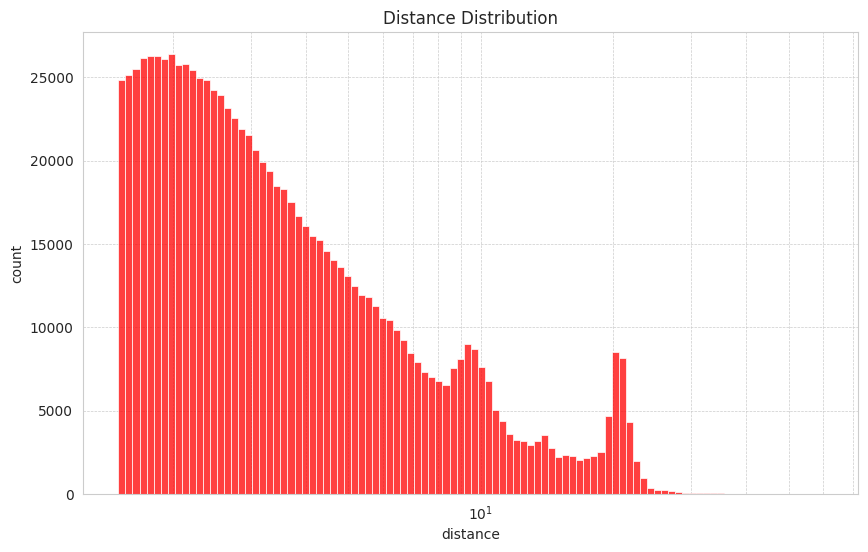

In [ ]:
trip_distance = taxi_df_week.select("distance").rdd.flatMap(lambda x: x).collect()

# plot the histogram with a log scale
plt.figure(figsize=(10,6))
sns.histplot(trip_distance, log_scale=True, bins=100, kde=False, color="red")

plt.title("Distance Distribution")
plt.xlabel("distance")
plt.ylabel("count")
plt.xscale("log") # set the scale of the x-axis to log
plt.yscale("linear")
plt.grid(True, which="both", ls="--", linewidth=0.5) # adding grid

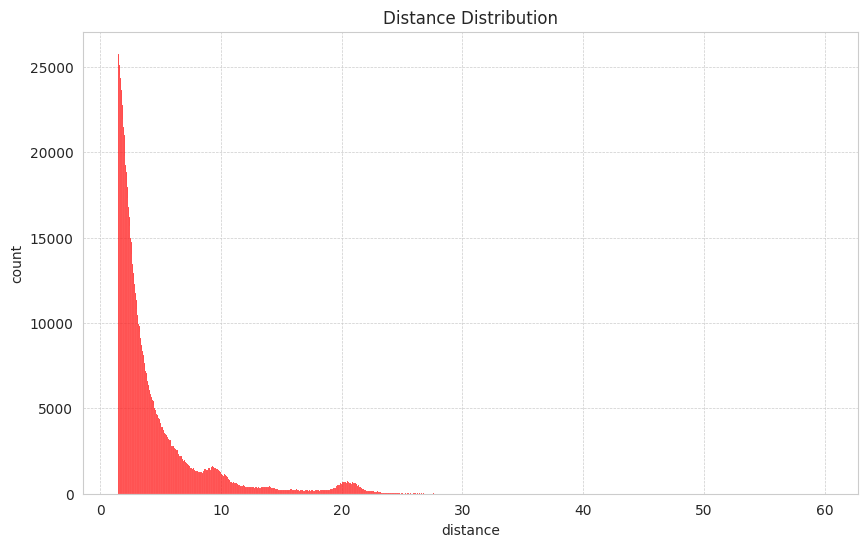

In [ ]:
# plot the histogram with a log scale
plt.figure(figsize=(10,6))
sns.histplot(trip_distance, bins=1000, kde=False, color="red")

plt.title("Distance Distribution")
plt.xlabel("distance")
plt.ylabel("count")
plt.yscale("linear")
plt.grid(True, which="both", ls="--", linewidth=0.5) # Adding a grid

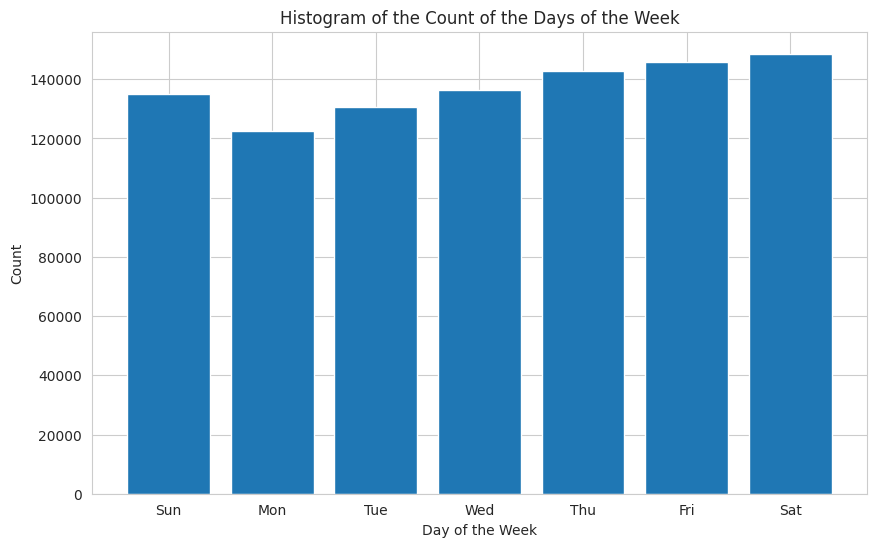

In [ ]:
# get count
week_day_counts = taxi_df_week.groupBy("week_day").count().orderBy("week_day")
week_day_counts_pd = week_day_counts.toPandas()

# plot days of the week
days_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

plt.figure(figsize=(10, 6))
plt.bar(week_day_counts_pd['week_day'], week_day_counts_pd['count'], tick_label=days_labels)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Histogram of the Count of the Days of the Week')
plt.xticks(range(1, 8))  # Set x-ticks to correspond to days of the week

In [ ]:
# calculate total trips and average passenger count
df_total_trip_on_diff_week_day = taxi_df_week.groupBy("week_day").count().alias("total_trips")
df_avg_pass_count = taxi_df_week.groupBy("week_day").agg(F.mean("passenger_count").alias("avg_passenger_count"))

# join the dataframes on week_day column
df_total_trip_pass_mean_on_diff_week_day = df_total_trip_on_diff_week_day.join(
    df_avg_pass_count, ["week_day"]
)

# collect the results in pandas dataframe
pandas_df = df_total_trip_pass_mean_on_diff_week_day.toPandas()

<Figure size 1000x500 with 0 Axes>

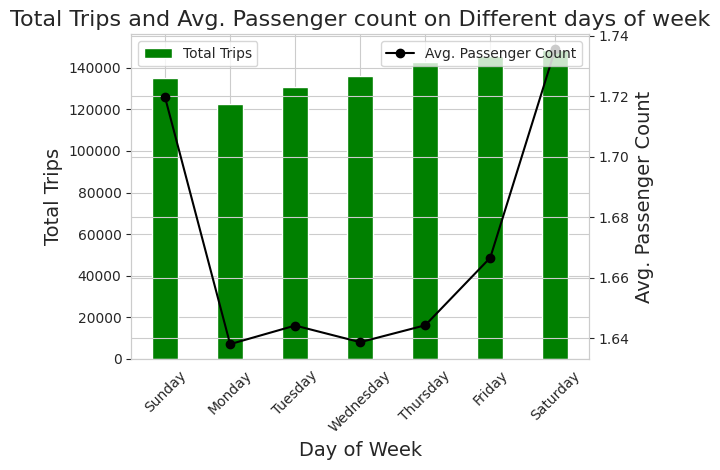

In [ ]:
pandas_df['week_day_name'] = pandas_df['week_day'].map(DAY_OF_WEEK_MAPPING)

pandas_df.sort_values('week_day', inplace=True)

x = pandas_df['week_day_name']
y1 = pandas_df['count']
y2 = pandas_df['avg_passenger_count']

plt.figure(figsize=(10, 5), dpi=100)
fig, first_axes = plt.subplots()

total_trip_duration = first_axes.bar(x, y1, color='green', width=0.4, label='Total Trips')

second_axes = first_axes.twinx()
mean_passenger_count, = second_axes.plot(x, y2, color="black", label='Avg. Passenger Count', marker='o')

first_axes.set_xlabel('Day of Week', fontsize=14)
first_axes.set_ylabel('Total Trips', fontsize=14)
second_axes.set_ylabel('Avg. Passenger Count', fontsize=14)

first_axes.legend(loc='upper left')
second_axes.legend(loc='upper right')

first_axes.set_xticks(range(len(x)))
first_axes.set_xticklabels(x, rotation=45)
plt.title('Total Trips and Avg. Passenger count on Different days of week', fontsize=16)
plt.grid(True)
plt.tight_layout()

<Figure size 1000x500 with 0 Axes>

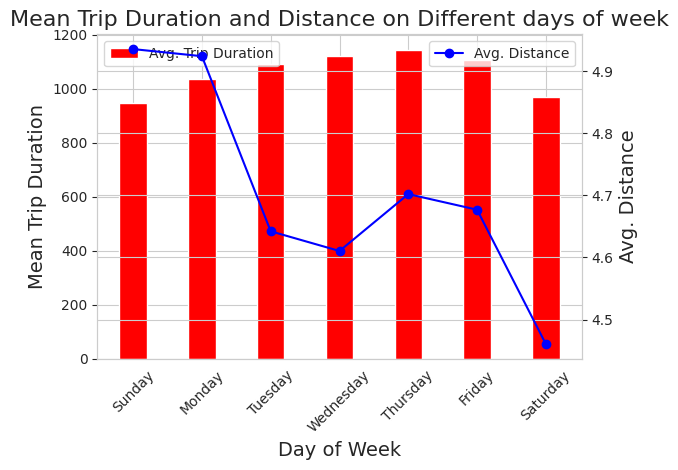

In [ ]:
# aggregate mean trip duration and mean distance
df_trip_dur_distance_mean_on_diff_week_day = taxi_df_week.groupBy("week_day") \
    .agg(
        F.mean("trip_duration").alias("avg_trip_duration"),
        F.mean("distance").alias("avg_distance")
    )

pandas_df = df_trip_dur_distance_mean_on_diff_week_day.toPandas()

# apply the day of the week mapping from the previous code block
pandas_df['week_day_name'] = pandas_df['week_day'].map(DAY_OF_WEEK_MAPPING)

pandas_df.sort_values('week_day', inplace=True)

x = pandas_df['week_day_name']
y1 = pandas_df['avg_trip_duration']
y2 = pandas_df['avg_distance']

# plot
plt.figure(figsize=(10, 5), dpi=100)
fig, first_axes = plt.subplots()

avg_trip_duration = first_axes.bar(x, y1, color='red', width=0.4, label='Avg. Trip Duration')

second_axes = first_axes.twinx()
mean_distance, = second_axes.plot(x, y2, color="blue", label='Avg. Distance', marker='o')

first_axes.set_xlabel('Day of Week', fontsize=14)
first_axes.set_ylabel('Mean Trip Duration', fontsize=14)
second_axes.set_ylabel('Avg. Distance', fontsize=14)

first_axes.legend(loc='upper left')
second_axes.legend(loc='upper right')

first_axes.set_xticks(range(len(x)))
first_axes.set_xticklabels(x, rotation=45)  # Rotate for better readability
plt.title('Mean Trip Duration and Distance on Different days of week', fontsize=16)
plt.grid(True)
plt.tight_layout()

In [ ]:
end = time.time()
delta_time = end - start
print(F"It took {delta_time} s to run the notebook.")

It took 995.1505377292633 s to run the notebook.
